In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import copy
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import cmocean as cmo
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import cmocean
warnings.filterwarnings("ignore")

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

cwd=os.getcwd()

In [2]:
def sort_longitude(_x, lon_min=-180.):
    if lon_min is None:
        return _x
    lon_max=lon_min + 360.

    x = _x.copy()

    for lon in ['xh', 'xq', 'lon']:
        try:
            lon = x[lon]
            if lon.min() < lon_min:
                lon = xr.where(lon<lon_min, lon+360, lon)
                lon = xr.where(lon>lon_max, lon-360, lon)
            else:
                lon = xr.where(lon>lon_max, lon-360, lon)
                lon = xr.where(lon<lon_min, lon+360, lon)   
            x[lon.name] = lon.copy()
            
            x = x.sortby(lon.name)
        except:
            pass
    return x

In [3]:
# EN4
max_depth = 749.9
ds = sort_longitude(xr.open_mfdataset('/vast/pp2681/EN4_dataset/annual/*.nc', decode_times=True).sel(time=slice('1998','2017')), lon_min=-300.).mean('time').compute()

dz_obs = xr.DataArray(np.diff(ds.depth_bnds).squeeze(), dims=['depth'], coords={'depth':ds.depth})
mask_obs = xr.where(np.isnan(ds.temperature), np.nan, 1.).sel(depth=slice(None,max_depth)).sum('depth')
mask_obs = xr.where(mask_obs == mask_obs.max(), 1., np.nan)

obs_en4 = mask_obs * ((ds.temperature - 273.15) * dz_obs).sel(depth=slice(None,max_depth)).sum('depth') / dz_obs.sel(depth=slice(None,max_depth)).sum('depth')
obs_sst_en4 = (ds.temperature - 273.15).isel(depth=0)

In [4]:
dz_obs.sel(depth=slice(None,max_depth)).sum('depth')

<xarray.DataArray ()> Size: 4B
array(725.1709, dtype=float32)

In [5]:
# HadISST
ds = sort_longitude(xr.open_dataset('/vast/pp2681/HadISST/HadISST_sst.nc').rename({'latitude': 'lat', 'longitude': 'lon'}), lon_min=-300.).sel(time=slice('1998', '2017'))
mask_nan = xr.where(np.isnan(ds.sst),np.nan,1.0).mean('time', skipna=False)
mask_all_vals = xr.where(ds.sst==-1000.,np.nan,1.).mean('time', skipna=False)
dt = np.diff(ds.time_bnds.values).reshape([240,1,1])
obs_sst_hardisst = (ds.sst * dt).sum('time') / np.sum(dt) * mask_nan * mask_all_vals
obs_sst_hardisst = obs_sst_hardisst.interp(lon=obs_sst_en4.lon, lat=obs_sst_en4.lat)

In [6]:
ds = sort_longitude(xr.open_dataset('/vast/pp2681/COBEv2_dataset/sst.mon.mean.nc'), lon_min=-300.).sel(time=slice('1998', '2017'))
obs_sst_cobe = (ds.sst * dt).sum('time', skipna=False) / np.sum(dt)
obs_sst_cobe = obs_sst_cobe.interp(lon=obs_sst_en4.lon, lat=obs_sst_en4.lat)

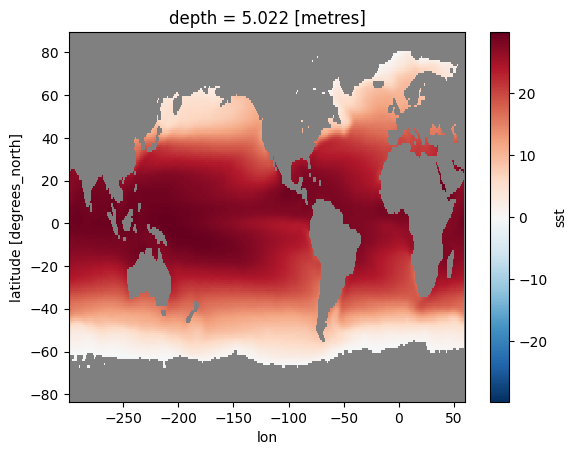

In [102]:
(obs_sst_hardisst).plot()
plt.gca().set_facecolor('gray')

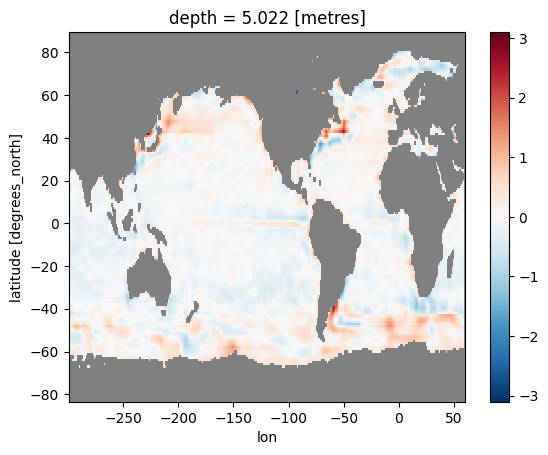

In [103]:
(obs_sst_hardisst - obs_sst_en4).plot()
plt.gca().set_facecolor('gray')

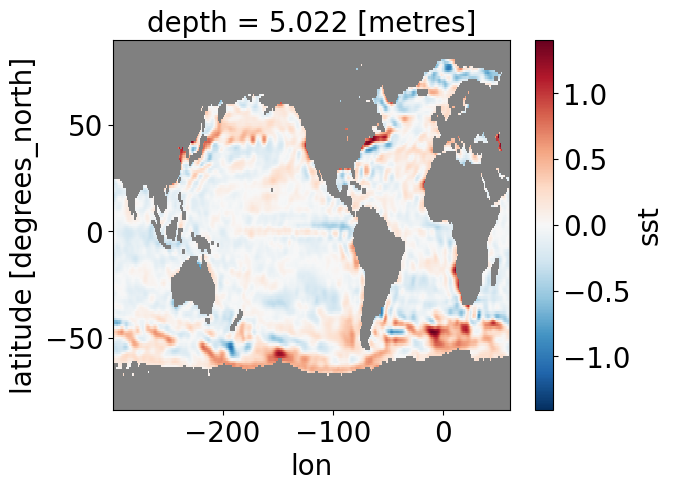

In [176]:
(obs_sst_hardisst - obs_sst_cobe).plot()
plt.gca().set_facecolor('gray')

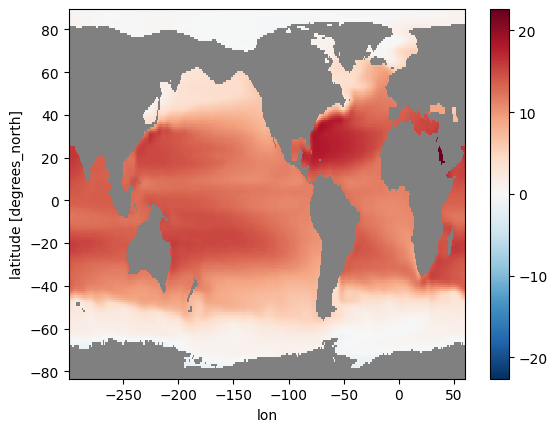

In [6]:
obs_en4.plot()
plt.gca().set_facecolor('gray')

In [7]:
param = xr.open_dataset('/vast/pp2681/OM5/ocean_monthly.static.nc')

In [8]:
import xesmf as xe

coords_in = xr.Dataset()
coords_in['lon'] = param.geolon
coords_in['lat'] = param.geolat
coords_in['lon_b'] = param.geolon_c#.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})
coords_in['lat_b'] = param.geolat_c#.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})

coords_out = xr.Dataset()
coords_out['lon'] = obs_en4.lon
coords_out['lat'] = obs_en4.lat
# This is one-degree grid
coords_out['lon_b'] = xr.DataArray((obs_en4.lon + 0.5).values, dims='lon_b').pad({'lon_b':(1,0)}, mode='wrap')
coords_out['lat_b'] = xr.DataArray((obs_en4.lat + 0.5).values, dims='lat_b').pad({'lat_b':(1,0)}, mode='symmetric')

regridder_nearest = xe.Regridder(coords_in, coords_out, "nearest_s2d", ignore_degenerate=True, periodic=True)
regridder_conserv = xe.Regridder(coords_in, coords_out, "conservative", ignore_degenerate=True, periodic=True)
#regridder_conserv = xe.Regridder(coords_in, coords_out, "conservative_normed", ignore_degenerate=True, periodic=True)

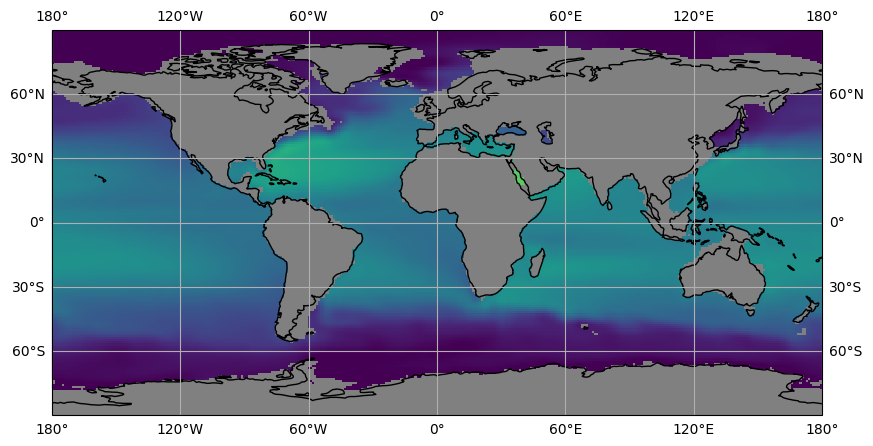

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
obs_en4.plot.pcolormesh(ax=ax, rasterized=True, cmap='viridis', vmin=0, vmax=30, add_colorbar=False)
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_facecolor('gray')
ax.set_ylim([-90,90])
plt.savefig('test1.pdf')

In [9]:
ds = xr.open_mfdataset('/scratch/pp2681/Wenda-directory/om5b11_control/ocean_annual_z.1998-2017.ann.nc')

In [10]:
dz = xr.DataArray(np.diff(ds.z_i), dims=['z_l'], coords={'z_l': ds.z_l})

In [11]:
dz.sel(z_l=slice(None,max_depth)).sum()

<xarray.DataArray ()> Size: 8B
array(750.)

In [12]:
mask = xr.where(np.isnan(ds.thetao.isel(time=0)), np.nan, 1.).sel(z_l=slice(None,max_depth)).sum('z_l')
mask = xr.where(mask == mask.max(), 1., np.nan)

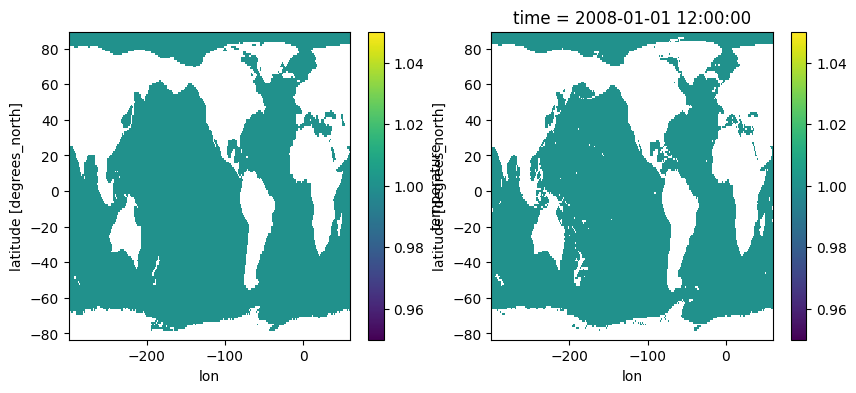

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
mask_obs.plot()

plt.subplot(1,2,2)
regridder_nearest(mask).plot()

In [14]:
max_depth=750.
ds = xr.open_dataset('/scratch/pp2681/Wenda-directory/om5b11_control/ocean_annual_z.1998-2017.ann.nc').isel(time=0)
control = mask * (dz * ds.thetao).sel(z_l=slice(None,max_depth)).sum('z_l').compute() / max_depth
control_sst = ds.thetao.isel(z_l=0)

ds = xr.open_dataset('/scratch/pp2681/Wenda-directory/ocean_annual_z.1998-2017.ann.nc').isel(time=0)
ann = mask * (dz * ds.thetao).sel(z_l=slice(None,max_depth)).sum('z_l').compute() / max_depth
ann_sst = ds.thetao.isel(z_l=0)

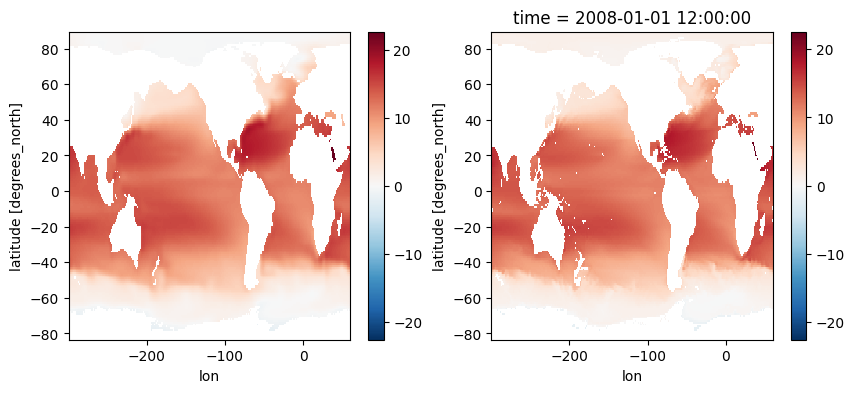

In [112]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
obs_en4.plot()

plt.subplot(1,2,2)
regridder_nearest(control).plot()

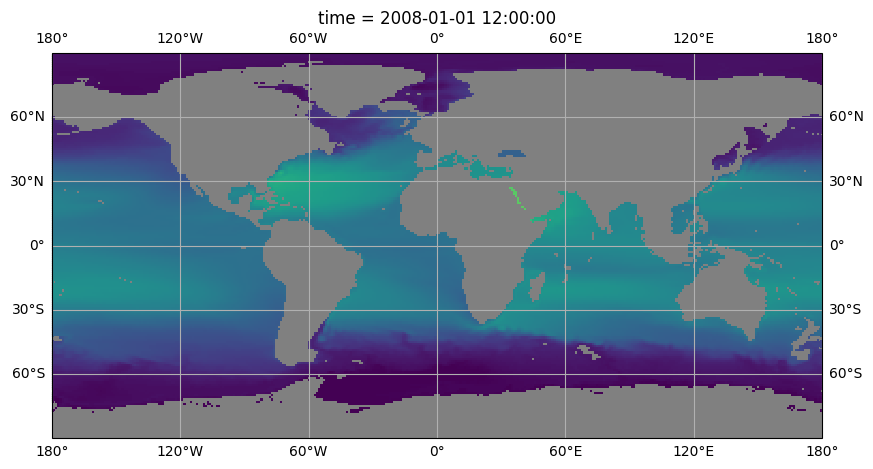

In [49]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
regridder_nearest(control).plot.pcolormesh(ax=ax, rasterized=True, cmap='viridis', vmin=0, vmax=30, add_colorbar=False)
ax.gridlines(draw_labels=True)
#ax.coastlines()
ax.set_facecolor('gray')
ax.set_ylim([-90,90])
plt.savefig('test2.pdf')

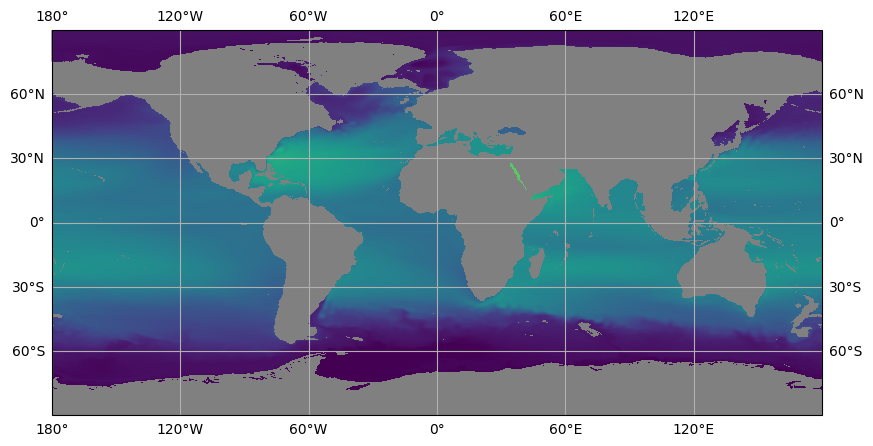

In [50]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolormesh(param.geolon, param.geolat,control, rasterized=True, cmap='viridis', vmin=0, vmax=30)
ax.gridlines(draw_labels=True)
#ax.coastlines()
ax.set_facecolor('gray')
ax.set_ylim([-90,90])
plt.savefig('test3.pdf')

# Final figures with 60-years runs

In [16]:
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
def plot_sst(control, parameterized, obs, label, regions={}, global_rmse=False, obs_text='EN4',
            cbar_label='1998-2017 and 0-750m \naveraged pot. temperature [$\degree $C]',
            area=False):    
    
    plot_no=[1,2]
    
    fig = plt.figure(figsize=(15,5), layout='constrained')
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.titlesize'] = 20

    x, y = obs['lon'], obs['lat']
    lon,lat=np.meshgrid(x,y)

    def compute_rmse(data):
        if area:
            # This is array proportional to local area
            # on lat-lon grid. We add data*0 to
            # fill it with NaNs same as data
            dxdy = np.cos(np.deg2rad(data.lat)) + data*0
            return np.sqrt((data**2 * dxdy).sum(skipna=True) / dxdy.sum(skipna=True))
        else:
            return np.sqrt((data**2).mean(skipna=True))
        
    for i in plot_no:
        
        ax = fig.add_subplot(1, 2, i, projection=ccrs.PlateCarree(central_longitude=60))
        gl = gridlines = ax.gridlines(draw_labels=True, linewidth=0.5,alpha=1.0, linestyle='-')
        gl.xtop_labels = False
        gl.xlabels_top = False
        gl.ylabels_right = False  

        # Define your desired longitude ticks (degrees)
        xticks = [-60, 0, 60, 180]
        gl.xlocator = mticker.FixedLocator(xticks)
        
        if i==1:
            data = control - obs  ### load the data to be plotted
            rmse = compute_rmse(data)
            
            cmap = plt.cm.RdYlBu_r
            
            #vmin,vmax,ci = -2.25,2.25,0.5
            vmin,vmax,ci = -0.9,0.9,0.2
            cilev = np.arange(vmin,vmax+ci,ci)
            
            pcm=ax.contourf(lon,lat,data, transform=ccrs.PlateCarree(),cmap=cmap, levels=cilev, extend='both')
            pcm.set_rasterized(True)

            if global_rmse:
                ax.set_title(f'Control - {obs_text}, global RMSE=%.3f $\degree $C' % rmse)
            else:
                ax.set_title(f'Control - {obs_text}')

            for key, val in regions.items():
                lon_range, lat_range, color = val
                regional_rmse = compute_rmse(data.sel(lon=slice(*lon_range), lat=slice(*lat_range)))
                rect = Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                                 linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=100)
                ax.add_patch(rect)
                ax.text(lon_range[0] + 1, lat_range[0] - 15, 'RMSE=%.2f$\degree $C' % regional_rmse, color=color, fontsize=12,
                                 transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=1.0, edgecolor=color), zorder=100)
                
        elif i==2:
            gl.ylabels_left = False  
            
            data = parameterized[0].data - control.data  ### load the data to be plotted
            cmap = plt.cm.RdYlBu_r

            error = parameterized[0] - obs  ### load the data to be plotted
            rmse = compute_rmse(error)
            
            #vmin,vmax,ci = -2.25,2.25,0.5
            vmin,vmax,ci = -0.9,0.9,0.2
            cilev = np.arange(vmin,vmax+ci,ci)
            
            pcm=ax.contourf(lon,lat,data, transform=ccrs.PlateCarree(),cmap=cmap, levels=cilev, extend='both')
            pcm.set_rasterized(True)
            if global_rmse:
                ax.set_title(f'{label[0]} - Control, global RMSE=%.3f $\degree $C' % rmse)
            else:
                ax.set_title(f'{label[0]} - Control')

            for key, val in regions.items():
                lon_range, lat_range, color = val
                regional_rmse = compute_rmse(error.sel(lon=slice(*lon_range), lat=slice(*lat_range)))
                rect = Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                                 linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=100)
                ax.add_patch(rect)
                ax.text(lon_range[0] + 1, lat_range[0] - 15, 'RMSE=%.2f$\degree $C' % regional_rmse, color=color, fontsize=12,
                                 transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=1.0, edgecolor=color), zorder=100)
            
        ax.set_facecolor('gray')
        ax.coastlines(rasterized=True)
    
    cbar = plt.colorbar(pcm, ax=plt.gca().axes, orientation='vertical', shrink=0.7)
    cbar.set_label(cbar_label, fontsize=16)
    cbar.ax.xaxis.set_tick_params(labelrotation=45)

In [16]:
regions={'Kuroshio': ((130,180), (20, 50), 'g'),
         'Gulf': ((-60,-10), (40, 60), 'r'),
         'ACC': ((10,190), (-60, -30), 'b'),
         'Indian': ((40,100), (0, 30), 'y'),
         'Arctic': ((30,-120+360), (70, 89), 'c')}

In [117]:
robs = sort_longitude(obs_en4, -120).compute()
rcontrol = sort_longitude(regridder_nearest(control),-120).drop_vars(['lon','lat']).compute()
rann = sort_longitude(regridder_nearest(ann),-120).drop_vars(['lon','lat']).compute()

CPU times: user 4.35 s, sys: 5.08 ms, total: 4.36 s
Wall time: 4.84 s


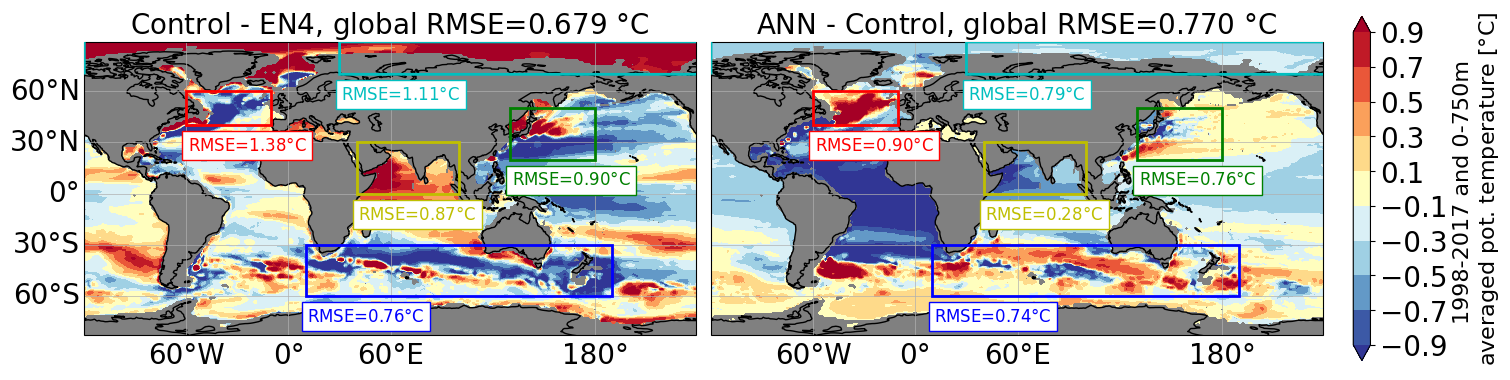

In [118]:
%time plot_sst(rcontrol, [rann], robs, label=['ANN'], regions=regions, global_rmse=True)

In [148]:
robs = sort_longitude(obs_sst_en4 * xr.where(np.isnan(obs_sst_hardisst),np.nan,1.), -120).compute()
rcontrol = sort_longitude(regridder_nearest(control_sst),-120).drop_vars(['lon','lat']).compute()
rann = sort_longitude(regridder_nearest(ann_sst),-120).drop_vars(['lon','lat']).compute()

rcontrol = xr.where(np.isnan(robs), np.nan, rcontrol)
rann = xr.where(np.isnan(robs), np.nan, rann)

CPU times: user 5.09 s, sys: 821 μs, total: 5.09 s
Wall time: 5.12 s


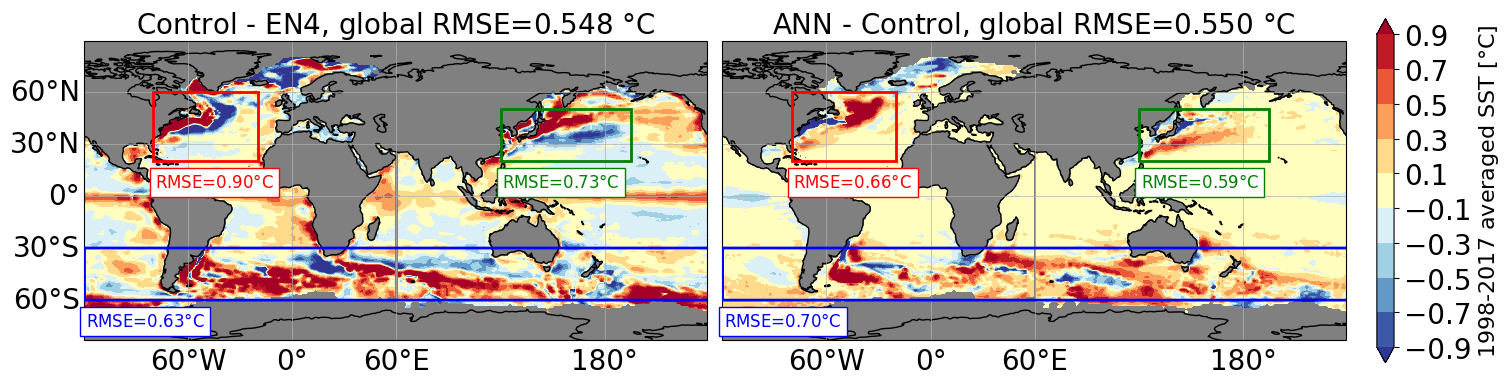

In [149]:
regions={'Kuroshio': ((120,195), (20, 50), 'g'),
         'Gulf': ((-80,-20), (20, 60), 'r'),
         'ACC': ((-120,240), (-60, -30), 'b')}

%time plot_sst(rcontrol, [rann], robs, label=['ANN'], regions=regions, global_rmse=True, cbar_label='1998-2017 averaged SST [$\degree $C]')

In [183]:
robs = sort_longitude(obs_sst_en4, -120).compute()
rcontrol = sort_longitude(regridder_nearest(control_sst),-120).drop_vars(['lon','lat']).compute()
rann = sort_longitude(regridder_nearest(ann_sst),-120).drop_vars(['lon','lat']).compute()

rcontrol = xr.where(np.isnan(robs), np.nan, rcontrol)
rann = xr.where(np.isnan(robs), np.nan, rann)

CPU times: user 6.42 s, sys: 4.71 ms, total: 6.43 s
Wall time: 6.46 s


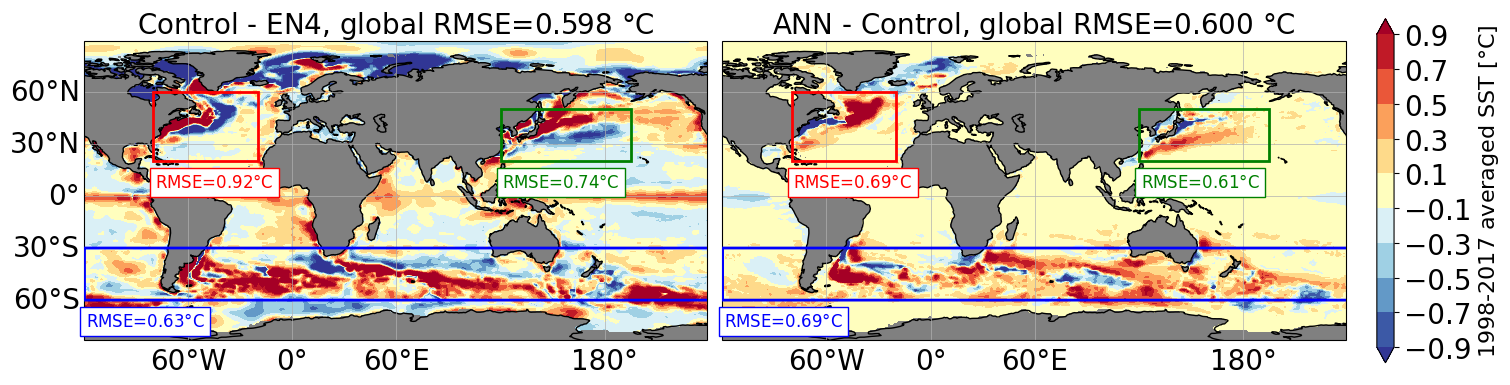

In [184]:
regions={'Kuroshio': ((120,195), (20, 50), 'g'),
         'Gulf': ((-80,-20), (20, 60), 'r'),
         'ACC': ((-120,240), (-60, -30), 'b')}

%time plot_sst(rcontrol, [rann], robs, label=['ANN'], regions=regions, global_rmse=True, cbar_label='1998-2017 averaged SST [$\degree $C]')

In [179]:
robs = sort_longitude(obs_sst_cobe * xr.where(np.isnan(obs_sst_hardisst),np.nan,1.), -120).compute()
rcontrol = sort_longitude(regridder_nearest(control_sst),-120).drop_vars(['lon','lat']).compute()
rann = sort_longitude(regridder_nearest(ann_sst),-120).drop_vars(['lon','lat']).compute()

rcontrol = xr.where(np.isnan(robs), np.nan, rcontrol)
rann = xr.where(np.isnan(robs), np.nan, rann)

CPU times: user 4.66 s, sys: 1.82 ms, total: 4.66 s
Wall time: 4.68 s


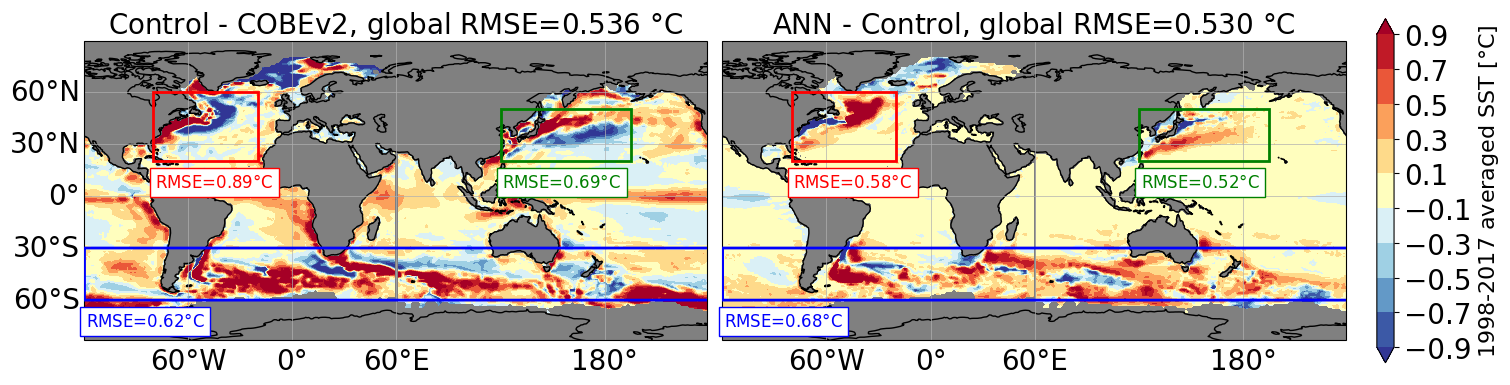

In [180]:
regions={'Kuroshio': ((120,195), (20, 50), 'g'),
         'Gulf': ((-80,-20), (20, 60), 'r'),
         'ACC': ((-120,240), (-60, -30), 'b')}

%time plot_sst(rcontrol, [rann], robs, label=['ANN'], regions=regions, obs_text='COBEv2', global_rmse=True, cbar_label='1998-2017 averaged SST [$\degree $C]')

In [17]:
robs = sort_longitude(obs_sst_cobe, -120).compute()
rcontrol = sort_longitude(regridder_nearest(control_sst),-120).drop_vars(['lon','lat']).compute()
rann = sort_longitude(regridder_nearest(ann_sst),-120).drop_vars(['lon','lat']).compute()

rcontrol = xr.where(np.isnan(robs), np.nan, rcontrol)
rann = xr.where(np.isnan(robs), np.nan, rann)

In [21]:
dy = 1
dx = np.cos(np.deg2rad(robs.lat))

data = (rcontrol-robs)# * 0 + 1
rmse = float(np.sqrt((data**2 * dx * dy).sum() / (xr.where(np.isnan(data),np.nan,1.) * dx * dy).sum()))
rmse_stupid = np.sqrt(np.nanmean(data**2))

print('rmse control-obs', round(rmse,3), round(rmse_stupid,3))

data = rann-robs
rmse = float(np.sqrt((data**2 * dx * dy).sum() / (xr.where(np.isnan(data),np.nan,1.) * dx * dy).sum()))
rmse_stupid = np.sqrt(np.nanmean(data**2))

print('rmse ann-obs', round(rmse,3), round(rmse_stupid,3))

rmse control-obs 0.489 0.523
rmse ann-obs 0.471 0.515


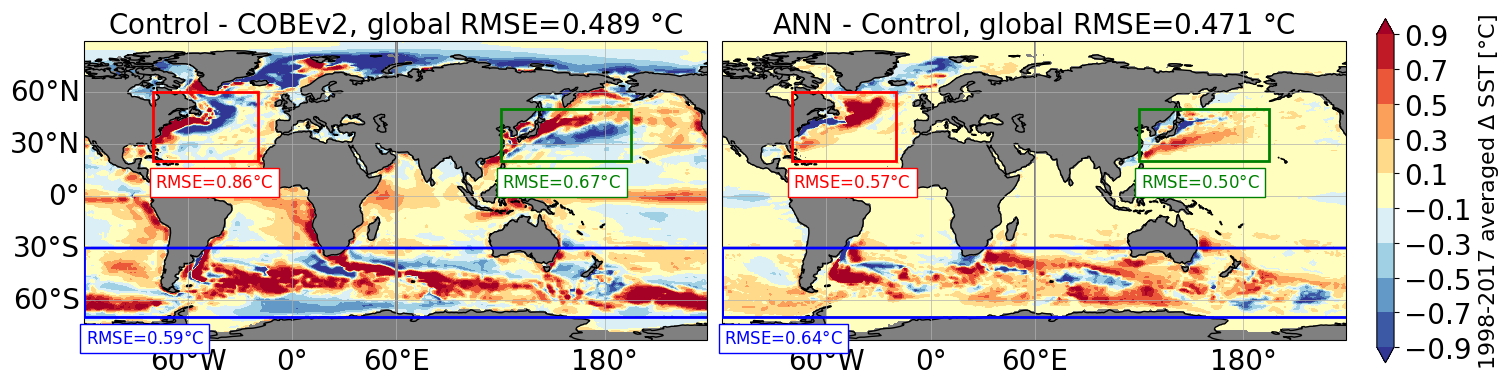

In [30]:
regions={'Kuroshio': ((120,195), (20, 50), 'g'),
         'Gulf': ((-80,-20), (20, 60), 'r'),
         'ACC': ((-120,240), (-70, -30), 'b')}

plot_sst(rcontrol, [rann], robs, label=['ANN'], 
         regions=regions, obs_text='COBEv2', 
         global_rmse=True, cbar_label='1998-2017 averaged $\Delta$ SST [$\degree $C]',
         area=True)
#plt.savefig('Figures-OM5/SST-COBE.pdf', bbox_inches='tight', dpi=150)

In [136]:
robs = sort_longitude(obs_sst_hardisst, -120).compute()
rcontrol = sort_longitude(regridder_nearest(control_sst),-120).drop_vars(['lon','lat']).compute()
rann = sort_longitude(regridder_nearest(ann_sst),-120).drop_vars(['lon','lat']).compute()

rcontrol = xr.where(np.isnan(robs), np.nan, rcontrol)
rann = xr.where(np.isnan(robs), np.nan, rann)

CPU times: user 4.76 s, sys: 11.5 ms, total: 4.77 s
Wall time: 4.79 s


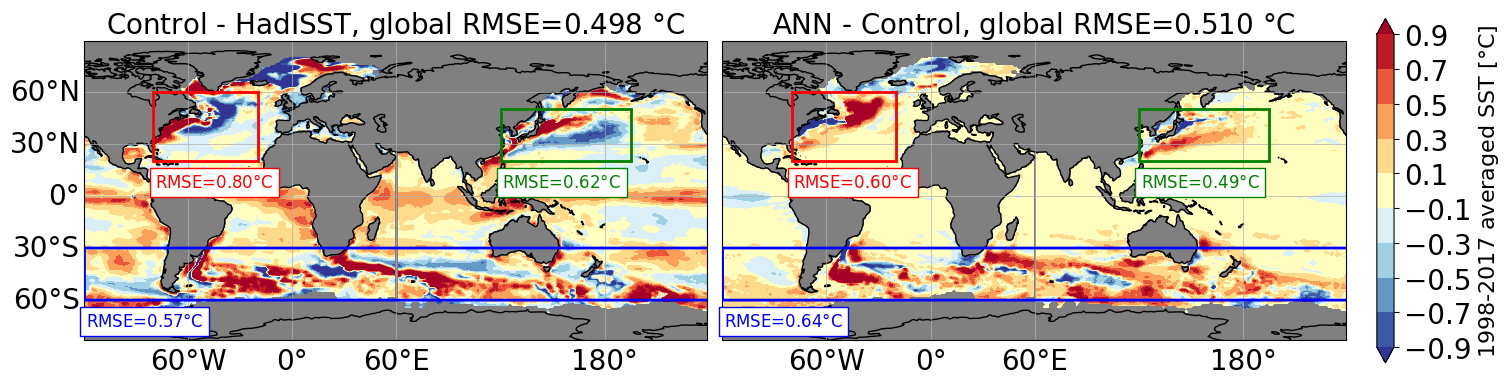

In [144]:
regions={'Kuroshio': ((120,195), (20, 50), 'g'),
         'Gulf': ((-80,-20), (20, 60), 'r'),
         'ACC': ((-120,240), (-60, -30), 'b')}

%time plot_sst(rcontrol, [rann], robs, label=['ANN'], regions = regions, global_rmse=True, cbar_label='1998-2017 averaged SST [$\degree $C]', obs_text='HadISST')
plt.savefig('Figures-OM5/SST-final.pdf', bbox_inches='tight', dpi=150)

CPU times: user 4.8 s, sys: 7.61 ms, total: 4.81 s
Wall time: 4.83 s


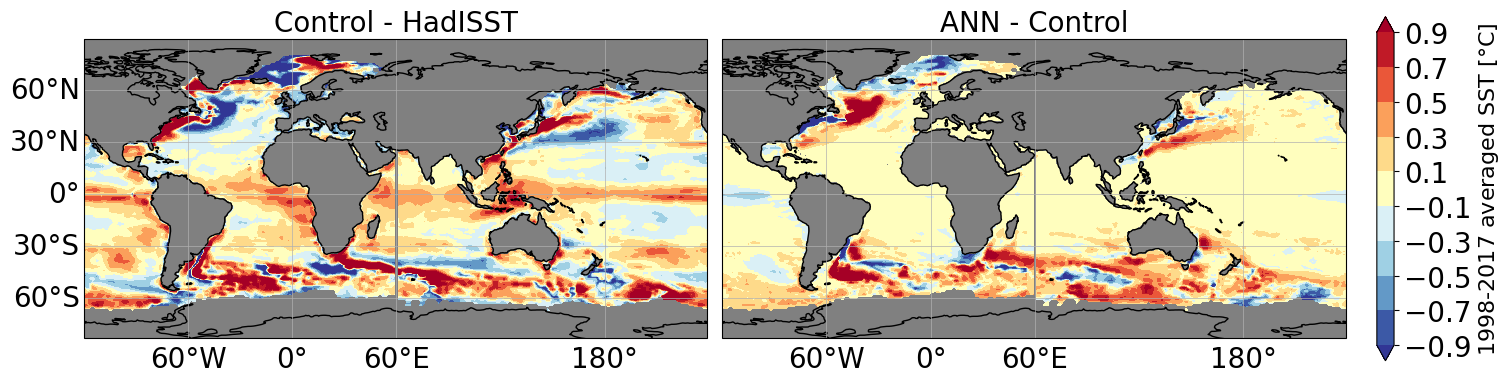

In [145]:
%time plot_sst(rcontrol, [rann], robs, label=['ANN'], cbar_label='1998-2017 averaged SST [$\degree $C]', obs_text='HadISST')
plt.savefig('Figures-OM5/SST-final-no-rmse.pdf', bbox_inches='tight', dpi=150)

# AMOC

In [3]:
control = xr.open_dataset('/scratch/pp2681/Wenda-directory/om5b11_control/ocean_annual_z.1998-2017.ann.nc').isel(time=0)
ann = xr.open_dataset('/scratch/pp2681/Wenda-directory/ocean_annual_z.1998-2017.ann.nc').isel(time=0)

In [22]:
from cmip_basins import generate_basin_codes
basincodes = generate_basin_codes(param, lon='geolon_v', lat='geolat_v', mask='wet_v').compute()
selected_codes = [2, 4, 6, 7, 8, 9]
mask = xr.where(basincodes.isin(selected_codes),1.,np.nan)

In [29]:
AMOC_control = - (control.vmo * mask).sum('xh').sel(yq=26.5, method='nearest').sel(z_l=slice(None,None,-1)).cumsum('z_l').isel(z_l=slice(None,None,-1)) / 1.035e9
AMOC_ann = - (ann.vmo * mask).sum('xh').sel(yq=26.5, method='nearest').sel(z_l=slice(None,None,-1)).cumsum('z_l').isel(z_l=slice(None,None,-1)) / 1.035e9

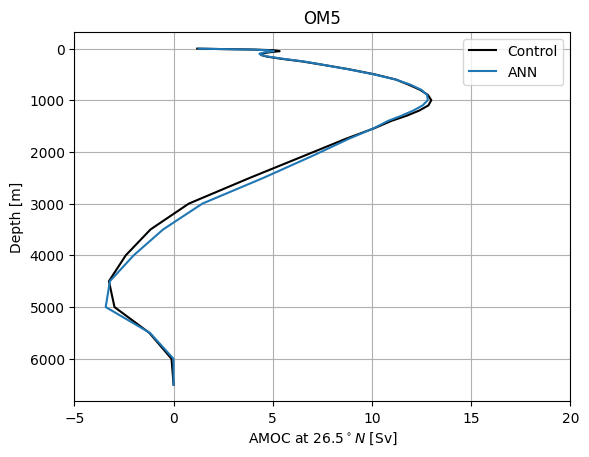

In [41]:
AMOC_control.plot(y='z_l', color='k', label='Control')
AMOC_ann.plot(y='z_l', label='ANN')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('AMOC at 26.5$^\circ N$ [Sv]')
plt.ylabel('Depth [m]')
plt.title('OM5')
plt.xlim([-5,20])
plt.grid()